# TP IPSSI - Sami Oliwer Lyes

Créer 2 dossiers "original_files" et "final_files" pour que tout fonctionne, sinon les Dataframe seront illisibles. Avoir un fichier .env avec les variables à la racine. Si besoin, contactez nous.

In [272]:
pip install pandas numpy matplotlib seaborn openpyxl lxml python-dotenv psycopg2 mysql-connector-python sqlalchemy pdfplumber unicodedata 

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement unicodedata (from versions: none)
ERROR: No matching distribution found for unicodedata


In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from IPython.display import display
import psycopg2
from psycopg2 import OperationalError
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pdfplumber
import sys

In [291]:
# Iterate through the PDF files in the 'original_files' directory
files = [f for f in os.listdir('original_files')]

for f in files:
    # Convert the PDF file to text and save it as an Excel file in 'converted_files'
    if f.endswith('.pdf'):
        lines = []
        with pdfplumber.open(f'./original_files/{f}') as pdf:
            for page in pdf.pages:
                text = page.extract_text()
                
                if text:  
                    for line in text.split('\n'):
                        line = line.replace(' ', ',')  
                        lines.append(line)
        
        data = [line.split(',') for line in lines]
        
        header = data[0]
        weather_data = data[1:]
        
                
        cleaned_weather_data = [row for row in weather_data if len(row) == len(header)]
 
        file = pd.DataFrame(cleaned_weather_data, columns=header)

        # save dataframe to csv
        file.to_csv(f'./final_files/{f[:-4]}_converti.csv', index=False)

    elif f.endswith('.json'):
        file = pd.read_json(f'./original_files/{f}')
        file.to_csv(f'./final_files/{f[:-5]}_converti.csv', index=False)
    elif f.endswith('.html'):
        file = pd.read_html(f'./original_files/{f}')
        file[0].to_csv(f'./final_files/{f[:-5]}_converti.csv', index=False)
    elif f.endswith('.xlsx'):
        file = pd.read_excel(f'./original_files/{f}')
    
        # Convert the DataFrame to CSV format
        csv_content = file.to_csv(index=False)
        
        # Replace all double-quote characters with an empty string
        csv_content = csv_content.replace('"', '')

        # Save the CSV file in the 'converted_files' directory
        with open(f'./final_files/{f[:-5]}_converti.csv', 'w') as f:
            f.write(csv_content)
        
    
weather = pd.read_csv('final_files/weather_converti.csv')
weather

planes = pd.read_csv('final_files/planes_converti.csv')
planes.replace('NaN', 0, inplace=True)
planes['speed'].fillna(0, inplace=True)
planes.drop(columns=['Unnamed: 0'], inplace=True)
planes


airlines = pd.read_csv('final_files/airlines_converti.csv')
airlines

airports = pd.read_csv('final_files/airports_converti.csv')
airports.drop(columns=['Unnamed: 0'], inplace=True)
airports

flights = pd.read_csv('final_files/flights_converti.csv')
flights.replace(" ", 0, inplace=True)
flights.drop_duplicates(subset=['flight'], inplace=True)

flights


FileNotFoundError: [Errno 2] No such file or directory: 'final_files/weather_converti.csv'

## Question1

1.	Combien y-a-t-il : 

-	d’aéroports en tout, de départ et de destination
-	Combien y-a-t-il d’aéroports où on ne passe pas à l’heure d’été (indice : colonne dst : 23) ? de fuseaux horaires (10 voir colone tzone dont une  « N »)
-	de compagnies, d’avions, de vols annulés ? 



In [275]:

all_airports = airports.shape[0]

print(f'Il y a {all_airports} aéroports dans le fichier airports.xlsx.')

#aéroports de départs et destinations
 
departures = flights['origin'].nunique()

print(f'Il y a {departures} aéroports de départ.')

destinations = flights['dest'].nunique()

print(f'Il y a {destinations} aéroports d\'arrivés.')

# Sans dest

no_dst = airports['dst'].value_counts()['N']

print(f'Il y a {no_dst} aéroports où on ne passe pas en heure d\'été.')
airports.head(25)

# Fuseaux

fuseaux = airports['tzone'].nunique()

print(f'Il y a {fuseaux} fuseaux horaires différents.')

# Avions

print(f'Il y a {planes.shape[0]} avions.')

Il y a 1458 aéroports dans le fichier airports.xlsx.
Il y a 3 aéroports de départ.
Il y a 99 aéroports d'arrivés.
Il y a 23 aéroports où on ne passe pas en heure d'été.
Il y a 10 fuseaux horaires différents.
Il y a 3322 avions.


In [276]:
companies = airlines.count()['name']

print(f'Il y a {companies} compagnies.')

Il y a 16 compagnies.


In [277]:
canceled_flights = flights[flights['dep_time'] == " "].shape[0]

print(f'Il y a {canceled_flights} vols annulés.')

Il y a 0 vols annulés.


# Question 2

2.	Quel est l’aéroport de départ le plus emprunté ? Quelles sont les 10 destinations les plus (moins) prisées (en indiquant le nom complet des destinations et non juste le code correspondant et le % corresp pour chaque destination) ? Quelle sont les 10 avions qui ont le plus (moins) décollé ?

In [278]:
# Quel est l'aéroport de départ le plus emprunté ?
aeroports_depart = flights['origin'].value_counts().reset_index()
aeroports_depart.columns = ['faa', 'nombre_vols']
 
# Joindre avec la table des aéroports pour obtenir les noms complets
aeroports_depart = aeroports_depart.merge(airports[['faa', 'name']], on='faa')
aeroport_plus_emprunte = aeroports_depart.iloc[0]
 
print(f"L'aéroport de départ le plus emprunté est : {aeroport_plus_emprunte['name']} avec {aeroport_plus_emprunte['nombre_vols']} vols")


L'aéroport de départ le plus emprunté est : Newark Liberty Intl avec 1757 vols


In [279]:
# Quelles sont les 10 destinations les plus (moins) prisées ?
# Comptage des destinations
destinations = flights['dest'].value_counts(normalize=True).reset_index()
destinations.columns = ['faa', 'pourcentage_vols']
 
# Conversion en pourcentage
destinations['pourcentage_vols'] *= 100
 
# Joindre avec la table des aéroports pour obtenir les noms complets
destinations = destinations.merge(airports[['faa', 'name']], on='faa')
 
# Top 10 des destinations les plus prisées
top_10_destinations = destinations.head(10)
print("Les 10 destinations les plus prisées :")
print(top_10_destinations[['name', 'pourcentage_vols']])
 
# Top 10 des destinations les moins prisées
bottom_10_destinations = destinations.tail(10)
print("Les 10 destinations les moins prisées :")
print(bottom_10_destinations[['name', 'pourcentage_vols']])

Les 10 destinations les plus prisées :
                                 name  pourcentage_vols
0              Charlotte Douglas Intl          4.682366
1        George Bush Intercontinental          4.162103
2  General Edward Lawrence Logan Intl          3.915663
3     Hartsfield Jackson Atlanta Intl          3.641840
4                  Chicago Ohare Intl          3.532311
5                 Chicago Midway Intl          3.477547
6              Detroit Metro Wayne Co          3.422782
7                         Denver Intl          3.368018
8                        Orlando Intl          2.601314
9      Fort Lauderdale Hollywood Intl          2.573932
Les 10 destinations les moins prisées :
                                 name  pourcentage_vols
86                    Sacramento Intl          0.027382
87                           Bob Hope          0.027382
88                             Yeager          0.027382
89                      Nantucket Mem          0.027382
90          Montrose Regi

In [280]:
# Quels sont les 10 avions qui ont le plus (moins) décollé ?
# Comptage des avions
avions = flights['tailnum'].value_counts().reset_index()
avions.columns = ['tailnum', 'nombre_vols']
 
# Joindre avec la table des avions pour obtenir des informations supplémentaires
avions = avions.merge(planes[['tailnum', 'model']], on='tailnum')
 
# Top 10 des avions les plus utilisés
top_10_avions = avions.head(10)
print("Les 10 avions qui ont le plus décollé :")
print(top_10_avions[['tailnum', 'model', 'nombre_vols']])
 
# Top 10 des avions les moins utilisés
bottom_10_avions = avions.tail(10)
print("Les 10 avions qui ont le moins décollé :")
print(bottom_10_avions[['tailnum', 'model', 'nombre_vols']])

Les 10 avions qui ont le plus décollé :
  tailnum            model  nombre_vols
0  N16561        EMB-145LR           11
1  N724EV      CL-600-2C10           11
2  N931XJ      CL-600-2D24           10
3  N755EV      CL-600-2C10           10
4  N11544        EMB-145LR           10
5  N13969        EMB-145LR            9
6  N8492C      CL-600-2B19            9
7  N951UW  ERJ 190-100 IGW            9
8  N10575        EMB-145LR            9
9  N713EV      CL-600-2C10            9
Les 10 avions qui ont le moins décollé :
     tailnum    model  nombre_vols
1647  N935WN  737-7H4            1
1648  N550WN  737-76Q            1
1649  N453UW  737-4B7            1
1650  N496WN  737-7H4            1
1651  N239WN  737-7H4            1
1652  N438WN  737-7H4            1
1653  N252WN  737-7H4            1
1654  N960WN  737-7H4            1
1655  N7739A  737-7BD            1
1656  N234WN  737-7H4            1


# Question 3

3.	Combien chaque compagnie a desservi de destination ; combien chaque compagnie a desservie de destination par aéroport d’origine. Réaliser les graphiques adéquats qui synthétisent ces informations ? 

C:\Users\Swerk\AppData\Local\Temp\ipykernel_87136\2141382427.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  xa = sns.barplot(x='carrier', y='dest', data=df, palette="viridis")


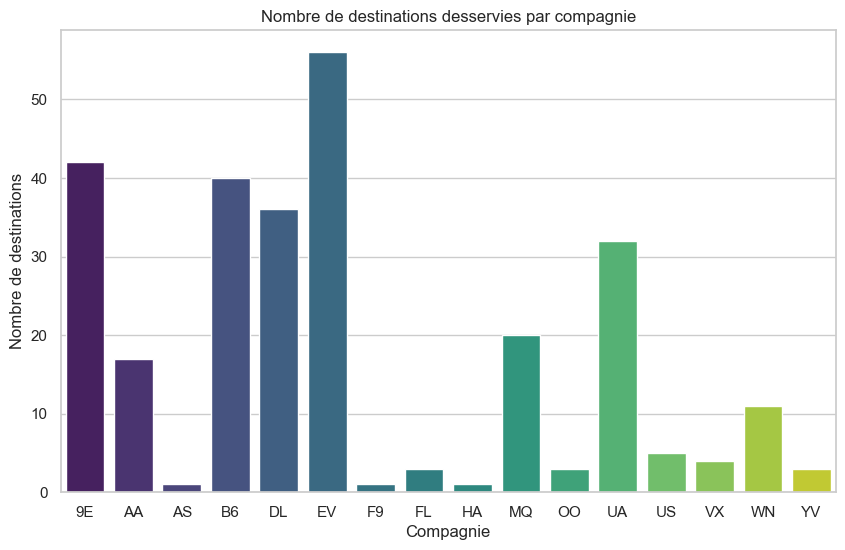

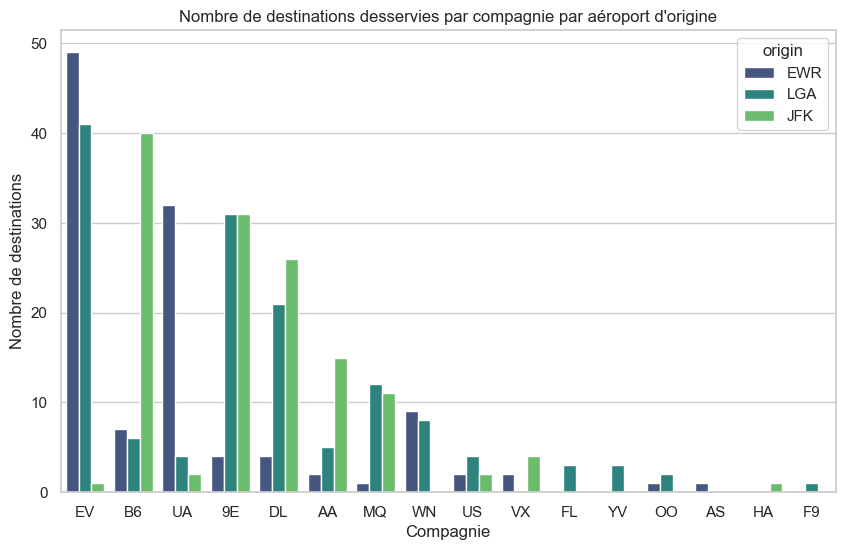

In [281]:
# Combien chaque compagnie a desservi de destination
## On initialise le dataframe qui contiendra les résultats

df = pd.DataFrame(flights)
## On groupe par compagnie, on compte le nombre de destinations, on reset l'index
df = df.groupby('carrier')['dest'].nunique().reset_index()

## on affiche
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
xa = sns.barplot(x='carrier', y='dest', data=df, palette="viridis")
plt.title('Nombre de destinations desservies par compagnie')
plt.xlabel('Compagnie')
plt.ylabel('Nombre de destinations')
plt.show()


# Combien chaque compagnie a desservie de destinations par aéroport d'origin

## Initialisation du dataframe
df = pd.DataFrame(flights)
## On groupe par compagnie et aéroport d'origin, on compte le nombre de destinations, on reset l'index
df = df.groupby(['origin', 'carrier'])['dest'].nunique().reset_index()
## On trie les résultats
df = df.sort_values(by='dest', ascending=False)

## Initialisation du graphique
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
xa = sns.barplot(x='carrier', y='dest', hue='origin', data=df, palette="viridis")
plt.title('Nombre de destinations desservies par compagnie par aéroport d\'origine')
plt.xlabel('Compagnie')
plt.ylabel('Nombre de destinations')
plt.show()




# Question 4
4.	Trouver tous les vols ayant atterri à Houston (IAH ou HOU) ? Combien de vols partent de NYC airports vers Seattle, combien de compagnies desservent cette destination et combien d’avions “uniques” ? 

In [282]:
flights_at_houston = flights[flights['dest'] == 'IAH'].count() + flights[flights['dest'] == 'HOU'].count()
flights_at_houston = flights_at_houston['carrier']

print(f'Il y a {flights_at_houston} vols à destination de Houston.')

flights_nyc_to_sea = flights[(flights['origin'].isin(['JFK', 'LGA', 'EWR'])) & (flights['dest'] == 'SEA')].count()
flights_nyc_to_sea = flights_nyc_to_sea['carrier']

print(f'Il y a {flights_nyc_to_sea} vols de New York à Seattle.')

companies_to_sea = flights[flights['dest'] == 'SEA']['carrier'].nunique()

print(f'Il y a {companies_to_sea} compagnies qui desservent Seattle.')

unique_planes = flights[flights['dest'] == 'SEA']['tailnum'].nunique()

print(f'Il y a {unique_planes} avions différents qui desservent Seattle.')

Il y a 191 vols à destination de Houston.
Il y a 24 vols de New York à Seattle.
Il y a 4 compagnies qui desservent Seattle.
Il y a 24 avions différents qui desservent Seattle.


# Question 5

5.	Trouver le nombre de vols par destination ? Trier les vols suivant la destination, l’aéroport d’origine, la compagnie dans un ordre alphabétique croissant (en réalisant les jointures nécessaires pour obtenir les noms explicites des aéroports) ?

In [283]:
# Nombre de vols par destination

## On initialise le dataframe qui contiendra les résultats
vols = flights[['dest', 'origin', 'carrier']]
## On groupe par destination et on compte le nombre de vols et on reset l'index
nb_vol_dest = vols.groupby('dest').size().reset_index(name='nombre_de_vols')

## On ajoute le nom des aéroports
## La fonction apply permet d'appliquer une fonction à chaque élément d'une colonne
## Ici, on applique une fonction lamba qui va chercher le nom des aéroports dans le dataframe airports
## Si l'aéroport n'est pas trouvé, on garde le code de l'aéroport
## Sinon on complète avec le nom de l'aéroport
nb_vol_dest['name'] = nb_vol_dest['dest'].apply(lambda x: airports[airports['faa'] == x]['name'].values[0] if not airports[airports['faa'] == x].empty else x)
print(nb_vol_dest)

print("=====================================")

# Triage des vols par destination, origine et compagn

## On initialise le dataframe qui contiendra les résultats
sorted_vols = flights[['dest', 'origin', 'carrier']]

## On groupe 
sorted_vols = vols.groupby(['dest', 'origin', 'carrier']).size().reset_index(name='nombre_de_vols')

sorted_vols['dest'] = sorted_vols['dest'].apply(lambda x: airports[airports['faa'] == x]['name'].values[0] if not airports[airports['faa'] == x].empty else x)
sorted_vols['carrier'] = sorted_vols['carrier'].apply(lambda x: airlines[airlines['carrier'] == x]['name'].values[0] if not airlines[airlines['carrier'] == x].empty else x)
sorted_vols = sorted_vols.sort_values(by=['dest', 'origin', 'carrier'], ascending=[False, False, True])

print(sorted_vols)


   dest  nombre_de_vols                               name
0   ABQ               1  Albuquerque International Sunport
1   ACK               1                      Nantucket Mem
2   ALB              15                        Albany Intl
3   ATL             133    Hartsfield Jackson Atlanta Intl
4   AUS              29              Austin Bergstrom Intl
..  ...             ...                                ...
94  SYR              27              Syracuse Hancock Intl
95  TPA              55                         Tampa Intl
96  TVC               2             Cherry Capital Airport
97  TYS               5                      Mc Ghee Tyson
98  XNA              11               NW Arkansas Regional

[99 rows x 3 columns]
                                  dest origin                      carrier  \
92                              Yeager    LGA                    Envoy Air   
166                    Wilmington Intl    LGA     ExpressJet Airlines Inc.   
156                    William P Ho

# Question 6 Lyes

6.	Quelles sont les compagnies qui n'opèrent pas sur tous les aéroports d’origine ? Quelles sont les compagnies qui desservent l’ensemble de destinations ?
Faire un tableau où l’on récupère l’ensemble des origines et des destinations pour l’ensemble des compagnies. 

In [284]:
# Quelles sont les compagnies qui n'opèrent pas sur tous les aéroports d’origine ?
total_origins = flights['origin'].nunique()
 
# Nombre d'aéroports d'origine desservis par chaque compagnie
compagnies_par_origine = flights.groupby('carrier')['origin'].nunique().reset_index()
compagnies_par_origine.columns = ['carrier', 'nombre_origines']
 
# Compagnies qui ne desservent pas tous les aéroports d'origine
compagnies_non_tous_origines = compagnies_par_origine[compagnies_par_origine['nombre_origines'] < total_origins]
 
# Joindre avec le nom des compagnies
compagnies_non_tous_origines = compagnies_non_tous_origines.merge(airlines[['carrier', 'name']], on='carrier')
 
print("Compagnies qui n'opèrent pas sur tous les aéroports d'origine :")
print(compagnies_non_tous_origines[['name', 'nombre_origines']])

Compagnies qui n'opèrent pas sur tous les aéroports d'origine :
                          name  nombre_origines
0         Alaska Airlines Inc.                1
1       Frontier Airlines Inc.                1
2  AirTran Airways Corporation                1
3       Hawaiian Airlines Inc.                1
4        SkyWest Airlines Inc.                2
5               Virgin America                2
6       Southwest Airlines Co.                2
7           Mesa Airlines Inc.                1


In [285]:
# Quelles sont les compagnies qui desservent l’ensemble des destinations ?
total_destinations = flights['dest'].nunique()
 
# Nombre de destinations desservies par chaque compagnie
compagnies_par_destination = flights.groupby('carrier')['dest'].nunique().reset_index()
compagnies_par_destination.columns = ['carrier', 'nombre_destinations']
 
# Compagnies qui desservent toutes les destinations
compagnies_toutes_destinations = compagnies_par_destination[compagnies_par_destination['nombre_destinations'] == total_destinations]
 
# Joindre avec le nom des compagnies
compagnies_toutes_destinations = compagnies_toutes_destinations.merge(airlines[['carrier', 'name']], on='carrier')
 
print("Compagnies qui desservent toutes les destinations :")
print(compagnies_toutes_destinations[['name', 'nombre_destinations']])

Compagnies qui desservent toutes les destinations :
Empty DataFrame
Columns: [name, nombre_destinations]
Index: []


In [286]:
# Tableau  de l'ensemble des origines et des destinations pour chaque compagnie
 
# Grouping by carrier, origin, and destination
tableau_origines_destinations = flights.groupby(['carrier', 'origin', 'dest']).size().reset_index(name='nombre_vols')
 
# Joindre avec les noms des compagnies, des aéroports d'origine et de destination
tableau_origines_destinations = tableau_origines_destinations.merge(airlines[['carrier', 'name']], on='carrier', how='left')
tableau_origines_destinations = tableau_origines_destinations.rename(columns={'name': 'carrier_name'})
 
tableau_origines_destinations = tableau_origines_destinations.merge(airports[['faa', 'name']], left_on='origin', right_on='faa', how='left')
tableau_origines_destinations = tableau_origines_destinations.rename(columns={'name': 'origin_name'}).drop(columns=['faa'])
 
tableau_origines_destinations = tableau_origines_destinations.merge(airports[['faa', 'name']], left_on='dest', right_on='faa', how='left')
tableau_origines_destinations = tableau_origines_destinations.rename(columns={'name': 'dest_name'}).drop(columns=['faa'])
 
print("Tableau des origines et destinations pour chaque compagnie :")
tableau_origines_destinations[['carrier_name', 'origin_name', 'dest_name', 'nombre_vols']]
 

Tableau des origines et destinations pour chaque compagnie :


,carrier_name,origin_name,dest_name,nombre_vols
0,Endeavor Air Inc.,Newark Liberty Intl,Hartsfield Jackson Atlanta Intl,1
1,Endeavor Air Inc.,Newark Liberty Intl,Cincinnati Northern Kentucky Intl,13
2,Endeavor Air Inc.,Newark Liberty Intl,Detroit Metro Wayne Co,24
3,Endeavor Air Inc.,Newark Liberty Intl,Minneapolis St Paul Intl,16
4,Endeavor Air Inc.,John F Kennedy Intl,Hartsfield Jackson Atlanta Intl,2
...,...,...,...,...
383,Southwest Airlines Co.,La Guardia,General Mitchell Intl,41
384,Southwest Airlines Co.,La Guardia,Lambert St Louis Intl,32
385,Mesa Airlines Inc.,La Guardia,Charlotte Douglas Intl,9
386,Mesa Airlines Inc.,La Guardia,Washington Dulles Intl,7


# Question 7 Oliwer

7.	Quelles sont les destinations qui sont exclusives à certaines compagnies ? 

In [287]:
# Destination exclusives à certaines compagnies

## On initialise un dataframe
df = pd.DataFrame(flights)

## On groupe par destination et on compte le nombre de compagnies desservant la destination
for item in df['dest'].unique():
    if(df[df['dest'] == item]['carrier'].nunique() == 1):
        print(f"La destination {item} est exclusivement desservie par la compagnie {df[df['dest'] == item]['carrier'].unique()[0]}.")


La destination IAH est exclusivement desservie par la compagnie UA.
La destination SNA est exclusivement desservie par la compagnie UA.
La destination MYR est exclusivement desservie par la compagnie EV.
La destination JAC est exclusivement desservie par la compagnie UA.
La destination MDW est exclusivement desservie par la compagnie WN.
La destination AVL est exclusivement desservie par la compagnie EV.
La destination SAV est exclusivement desservie par la compagnie EV.
La destination CAK est exclusivement desservie par la compagnie FL.
La destination LGB est exclusivement desservie par la compagnie B6.
La destination ALB est exclusivement desservie par la compagnie EV.
La destination MSN est exclusivement desservie par la compagnie EV.
La destination GSO est exclusivement desservie par la compagnie EV.
La destination BUR est exclusivement desservie par la compagnie B6.
La destination SJC est exclusivement desservie par la compagnie B6.
La destination OMA est exclusivement desservie p

# Question 8 Sami
8.	Filtrer le vol pour trouver ceux exploités par United, American ou Delta ?

In [288]:
# merge1 : flights - airlines : career 

flights_airlines = flights.merge(airlines, how='outer', on='carrier')
flights_airlines

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour,name
0,2021,1,1,810,810,0,1048,1037,11,9E,3538,N915XJ,JFK,MSP,189,1029,8,10,2021-01-01T08:00:00Z,Endeavor Air Inc.
1,2021,1,1,1451,1500,-9,1634,1636,-2,9E,4105,N8444F,JFK,IAD,57,228,15,0,2021-01-01T15:00:00Z,Endeavor Air Inc.
2,2021,1,1,1452,1455,-3,1637,1639,-2,9E,3295,N920XJ,JFK,BUF,68,301,14,55,2021-01-01T14:00:00Z,Endeavor Air Inc.
3,2021,1,1,1454,1500,-6,1635,1636,-1,9E,3843,N8409N,JFK,SYR,57,209,15,0,2021-01-01T15:00:00Z,Endeavor Air Inc.
4,2021,1,1,1530,1530,0,1650,1655,-5,9E,3369,N913XJ,JFK,BWI,40,184,15,30,2021-01-01T15:00:00Z,Endeavor Air Inc.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3647,2021,4,6,1846,1855,-9,2043,2058,-15,YV,2842,N921FJ,LGA,CLT,82,544,18,55,2021-04-06T18:00:00Z,Mesa Airlines Inc.
3648,2021,4,9,1737,1740,-3,1926,1943,-17,YV,2705,N925FJ,LGA,CLT,78,544,17,40,2021-04-09T17:00:00Z,Mesa Airlines Inc.
3649,2021,4,11,1634,1603,31,1748,1730,18,YV,3790,N507MJ,LGA,IAD,47,229,16,3,2021-04-11T16:00:00Z,Mesa Airlines Inc.
3650,2021,5,5,1727,1740,-13,1929,1943,-14,YV,2671,N913FJ,LGA,CLT,92,544,17,40,2021-05-05T17:00:00Z,Mesa Airlines Inc.


In [289]:
airlines_to_include = ['American Airlines Inc.', 'Delta Air Lines Inc.', 'United Air Lines Inc.']

flights_airlines.groupby('name')['flight'].count()

filtered_flights = flights_airlines[flights_airlines['name'].isin(airlines_to_include)]

result = filtered_flights.groupby('name')['flight'].count()

print(f'Voici le nombre de vols exploités par ces 3 compagnies : \n {result}')

Voici le nombre de vols exploités par ces 3 compagnies : 
 name
American Airlines Inc.    111
Delta Air Lines Inc.      328
United Air Lines Inc.     867
Name: flight, dtype: int64


# Partie 2

Base de données 

Connexion

In [290]:
from sqlalchemy import text
load_dotenv()
dbname = os.getenv('DB_NAME')
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')

# Write the planes DataFrame to the SQL table

try:
    engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{dbname}')
    connection = engine.connect()
except Exception as e:
    print(f"Error: {e}")


# Check if the airport exists for each flight, if not, shift the flight
flights = flights[flights['origin'].isin(airports['faa']) & flights['dest'].isin(airports['faa'])]

# check if the airline exists for each flight, if not, shift the flight
flights = flights[flights['carrier'].isin(airlines['carrier'])]

# check if the plane exists for each flight, if not, shift the flight
flights = flights[flights['tailnum'].isin(planes['tailnum'])]

airports.to_sql('airports', engine, if_exists='append', index=False)
airlines.to_sql('airlines', engine, if_exists='append', index=False)
planes.to_sql('planes', engine, if_exists='append', index=False)
weather.to_sql('weather', engine, if_exists='append', index=False)
flights.to_sql('flights', engine, if_exists='append', index=False)


336

## Chargement des données vers la base de données